In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import random
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import cm, colors
import matplotlib.colors as mcolors
import matplotlib.colors
from utils import *

In [2]:
# parameters
focal_year = 2020

**S1 - data description**

In [3]:
data = pd.read_csv("../data/languages.csv")

In [4]:
data.nunique()

num_pushers      12624
language           384
language_type        4
iso2_code          164
year                 4
quarter              4
dtype: int64

**S2 - ECI comparison details**

In [3]:
# read in 3 other ECI measures
trade_eci = pd.read_csv("../data/eci_hs6_hs96_trade.csv")
trade_eci = trade_eci[["Country", "2020"]]
tech_eci = pd.read_csv("../data/eci_tech.csv")
tech_eci = tech_eci[["Country", "2020"]]
research_eci = pd.read_csv("../data/Data-ECI-Research.csv")
research_eci = research_eci[["Country", "2020"]]

In [8]:
def mat_reshape(path, column_labels):
    """to reshape the matrices from Viktor Stojkoski"""
    mat = pd.read_csv(path)
    mat.set_index("Row", inplace=True)
    mat = mat.unstack().reset_index()
    mat.columns = column_labels
    return mat

In [9]:
trade_df = mat_reshape(path="../data/stojkoski_etal_data/trade_matrix_data_2020.csv", column_labels=["product", "iso3_code", "value"])
patent_df = mat_reshape(path="../data/stojkoski_etal_data/pct_data_2020.csv", column_labels=["class", "iso3_code", "value"])
research_df = mat_reshape(path="../data/stojkoski_etal_data/pub_matrix_data_2020.csv", column_labels=["category", "iso3_code", "value"])

In [10]:
trade_df

,product,iso3_code,value
0,AbrasivePowder,AFG,4
1,AbrasivePowder,ALB,321
2,AbrasivePowder,DZA,47835
3,AbrasivePowder,ASM,0
4,AbrasivePowder,AND,174
...,...,...,...
289099,Zirconium,WLF,0
289100,Zirconium,YEM,0
289101,Zirconium,YUG,0
289102,Zirconium,ZMB,0


**S3 - comparison of ECI values**

In [26]:
comp_df = pd.read_csv("../outputs/eci_comparisons_2020.csv", sep=";")

In [27]:
export_eci = comp_df[["iso3_code", "software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]].dropna(subset=["software_eci_2020"]).sort_values(by="software_eci_2020", ascending=False).drop_duplicates()
eci_cols = ["software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]
export_eci[eci_cols] = export_eci[eci_cols].round(3)
export_eci.to_csv("../outputs/si_eci_comparison_table.csv", sep=";")

**S6 - fully labeled language space**

In [5]:
# MST graph from proximity values
mst_version = False
proximity = pd.read_csv("../outputs/proximity_2020_2023.csv", sep=";")
proximity = proximity[proximity["year"] == 2020]
space_table = edgelist_cleaning_for_software_space(proximity, key_columns=["language_1", "language_2", "proximity"])
mst_el = maximum_spanning_tree(space_table, key_columns=["language_1", "language_2", "proximity"])
mst_graph = nx.from_pandas_edgelist(mst_el, source="language_1", target="language_2")

# MST or MST + strongest ties to have 1/3 ratio of nodes/edges
if mst_version==True:
    el = mst_el
    selected_seed = 15
    print("MST version")
else:
    n_nodes = mst_graph.number_of_nodes()
    n_edges = n_nodes * 2
    el = add_edges(mst_el, space_table, nr_edges_to_add=n_edges)
    #selected_seed = 15
    selected_seed = 99
    print("MST and additional ties version")

# complexity table to filter for lanuages in countries with RCA >= 1
cdf = pd.read_csv("../outputs/eci_software_2020_2023.csv", sep=";")
cdf = cdf[cdf["year"] == 2020]

# entry and exit data
entry = pd.read_csv("../outputs/data_entry_regressions_0011.csv", sep=";")
exit = pd.read_csv("../outputs/data_exit_regressions_1100.csv", sep=";")

MST and additional ties version


In [6]:
def software_space_of_country(el, complexity_table, country_code):
    # filter for the focal country and RCA
    ctable = complexity_table.query("iso2_code == @country_code and rca >= 1")[["language", "rca"]].drop_duplicates()

    # merge the dataframes more concisely
    cel = el.merge(ctable, left_on="language_1", right_on="language", how="left") \
            .merge(ctable, left_on="language_2", right_on="language", how="left", suffixes=["_i", "_j"])

    # filter and select relevant columns
    cel_filtered = cel.dropna(subset=["rca_i", "rca_j"])[["language_1", "language_2", "proximity"]]

    return cel_filtered

# software_space_of_country(mst_el, cdf, country_code="HU")

In [9]:
# common settings
def custom_graphviz_layout(G, seed=None, **kwargs):
    """graphviz layout does not have a built in seed option"""
    
    # set the random seed if provided
    if seed is not None:
        random.seed(seed)
    # call the original graphviz_layout function with any additional kwargs
    return nx.drawing.nx_agraph.graphviz_layout(G, **kwargs)

ss_graph = nx.from_pandas_edgelist(el, source="language_1", target="language_2")
pos = custom_graphviz_layout(ss_graph, seed=selected_seed, prog='neato')
pos = {key: (value[0]*1.2, value[1]) for key, value in pos.items()}

(-198.993042, 2613.192642, -86.349, 1116.1490000000001)

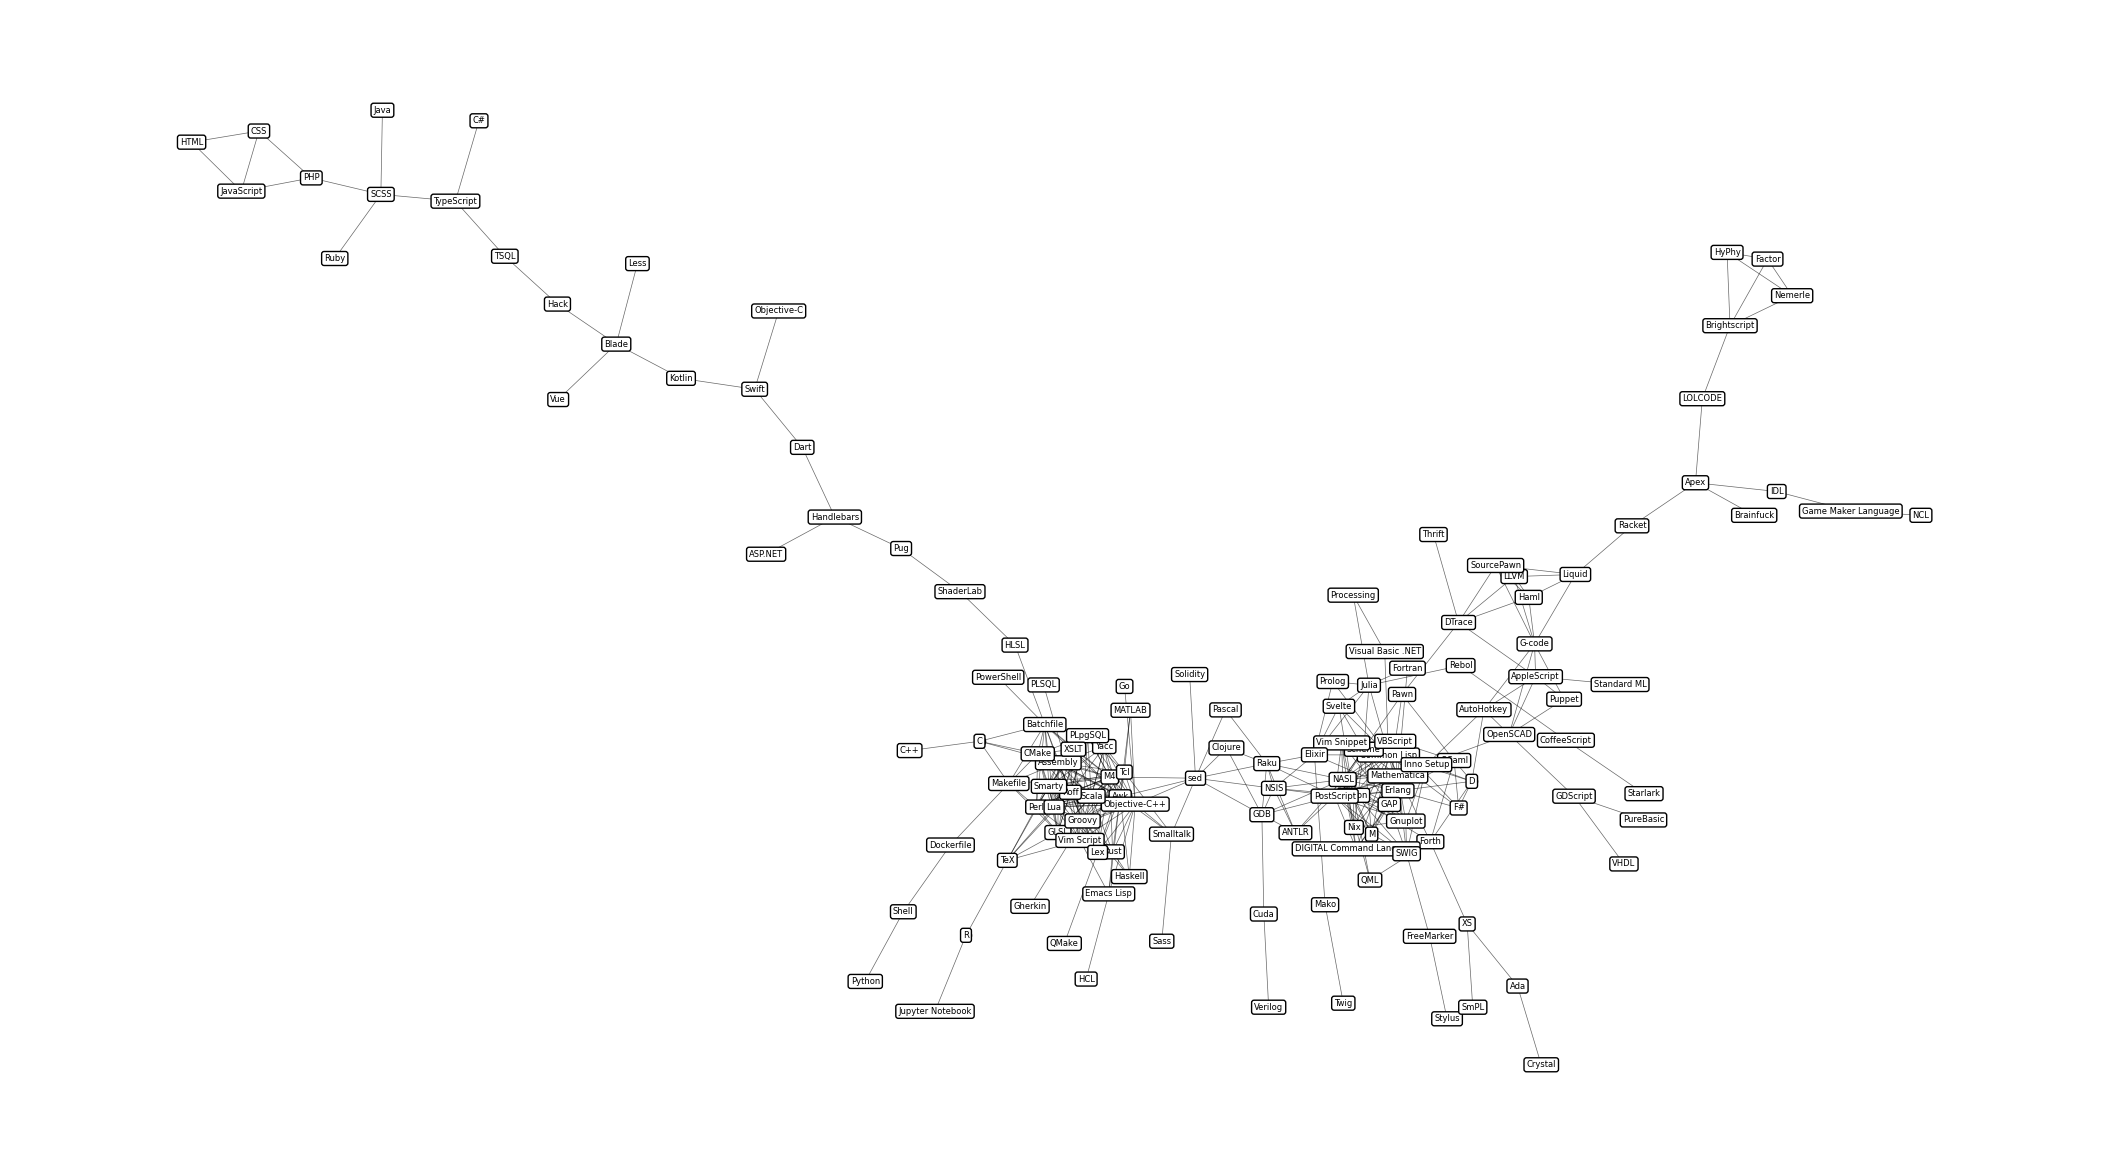

In [25]:
fontsize = 14
rca_color = "#0F3D80"

fig, ax = plt.subplots(1,1, figsize=(27,15))

nx.draw_networkx_edges(
    ss_graph,
    pos=pos,
    edge_color="black",
    width=.5,
    alpha=.6,
    ax=ax
)
nx.draw_networkx_nodes(
    ss_graph,
    pos,
    node_size=50,
    node_color=rca_color,
    linewidths=1.2,
    edgecolors='black',
    ax=ax
)
nx.draw_networkx_labels(
    ss_graph,
    bbox = dict(facecolor = "white",
    boxstyle="round"),
    pos=pos,
    font_size=fontsize-8,
    ax=ax
)
ax.axis('off')

# plt.savefig("../figures/s6_labeled_language_space.png", bbox_inches='tight', dpi=300, facecolor="white")

**SI 17 - correlation of ECI_software values over time**

In [5]:
# data -- ECI_software
cdf = pd.read_csv("../outputs/eci_software_2020_2023.csv", sep=";")
cdf = cdf[["iso2_code", "eci", "year"]].drop_duplicates()

In [10]:
# correlation matrix over time
pivoted = cdf.pivot(index="iso2_code", columns="year", values="eci")

# compute correlation matrix across years
correlation_matrix = pivoted.corr().round(3)

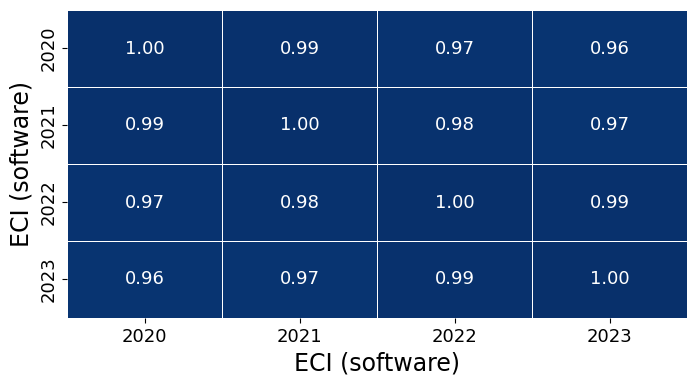

In [22]:
# heatmap
fig, ax = plt.subplots(1,1, figsize=(8,4))
fontsize=17
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False, center=0, linewidths=0.5, annot_kws={"size": fontsize-4}, ax=ax)
ax.set_xlabel("ECI (software)", size=fontsize)
ax.set_ylabel("ECI (software)", size=fontsize)
ax.tick_params("x", labelsize=(fontsize-4))
ax.tick_params("y", labelsize=(fontsize-4))

# plt.savefig("../figures/s17_correlation_heatmap.png", bbox_inches='tight', dpi=300, facecolor="white")